## Opening docs

In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import re
import string
import os
import networkx as nx
import codecs
from os import path

from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


In [2]:
# %load ../../utils/read_data.py
import networkx as nx
import codecs
import os
from os import path

def get_data_train(data_path='./data/'):
    with open(path.join(data_path, "train.csv"), 'r') as f:
        train_data = f.read().splitlines()

    train_hosts = list()
    y_train = list()
    for row in train_data:
        host, label = row.split(",")
        train_hosts.append(host)
        y_train.append(label.lower())

    # Text data
    # Load the textual content of a set of webpages for each host into the dictionary "data".
    # The encoding parameter is required since the majority of our data is french.
    text = dict()
    text_path = path.join(data_path, 'text/')
    filenames = os.listdir(text_path)

    for filename in filenames:
        try:
            with codecs.open(path.join(text_path, filename), encoding='utf-8') as f:
                text[filename] = f.read().replace("\n", "").lower()
        except:
            with codecs.open(path.join(text_path, filename), encoding='latin-1') as f:
                text[filename] = f.read().replace("\n", "").lower()

    X_train = list()
    for host in train_hosts:
        if host in text:
            X_train.append([host, text[host]])
        else:
            X_train.append([host, ''])

    return X_train, y_train


def get_data_full(data_path='./data/'):
    with open(path.join(data_path, "train.csv"), 'r') as f:
        train_data = f.read().splitlines()
    with open(path.join(data_path, "test.csv"), 'r') as f:
        test_hosts = f.read().splitlines()

    train_hosts = list()
    y_train = list()
    for row in train_data:
        host, label = row.split(",")
        train_hosts.append(host)
        y_train.append(label.lower())

    # Text data
    # Load the textual content of a set of webpages for each host into the dictionary "data".
    # The encoding parameter is required since the majority of our data is french.
    text = dict()
    text_path = path.join(data_path, 'text/')
    filenames = os.listdir(text_path)

    for filename in filenames:
        try:
            with codecs.open(path.join(text_path, filename), encoding='utf-8') as f:
                text[filename] = f.read().replace("\n", "").lower()
        except:
            with codecs.open(path.join(text_path, filename), encoding='latin-1') as f:
                text[filename] = f.read().replace("\n", "").lower()

    X_train = list()
    for host in train_hosts:
        if host in text:
            X_train.append([host, text[host]])
        else:
            X_train.append([host, ''])
    # Get textual content of web hosts of the test set
    X_test = list()
    for host in test_hosts:
        if host in text:
            X_test.append([host, text[host]])
        else:
            X_test.append([host, ''])
    return X_train, y_train, X_test, test_hosts


In [3]:
X_train, y_train, X_test, test_hosts = get_data_full(data_path='../../data/') 

In [4]:
data_train = pd.DataFrame({'text': X_train,'category': y_train,})
data_train[['train_host','text']] = pd.DataFrame(data_train.text.values.tolist(), index= data_train.index)
data_train.set_index('train_host', inplace=True)
data_train.head()

,text,category
train_host,,
9032,#polepharma » flux polepharma » flux des commentaires alternate alternate polepharma polepharma ﻿ recherche_________ submit (button) toggle navigation polepharma * polepharma ...,health/medical
5346,301 moved permanently __________________________________________________________________ nginx 301 mov...,entertainment
18778,"(button) fermer en poursuivant votre navigation sans modifier vos paramètres de cookies, vous acceptez l'utilisation des cookies pour disposer de services et d'offres adaptés à vos centre...",entertainment
11939,#hal (button) toggle navigation ccsd * hal + hal + halshs + tel + médihal + liste des portails + + auréhal + api ...,education/research
17502,user-agent: * disallow: disallow: /publishers user-agent: yandex crawl-delay: 3 sitemap: https://www.soft32.com/sitemap.xml télécharger des logiciels gratuits pour windows | soft32 * ac...,tech/science


In [5]:
data_test = pd.DataFrame({'text': X_test,})
data_test[['test_host','text']] = pd.DataFrame(data_test.text.values.tolist(), index= data_test.index)
data_test.set_index('test_host', inplace=True)
data_test.head()

,text
test_host,
27997,iframe: //www.googletagmanager.com/ns.html?id=gtm-k598bts skip to main content * about * alumni * news & events * give * go griffs * my canisiussearch form search __...
9316,iframe: https://www.googletagmanager.com/ns.html?id=gtm-mhb3554 [p?c1=7&c2=20061681&c3=1000055&cv=2.0&cj=1] poki facebook logo 722k youtube logo 362k ____________________ (button) (bu...
27045,#toutes les astuces beauté ⋅ astuces beauté ⋅ sephora à la une ⋅ astuces beauté ⋅ sephora sephora x richaard ⋅ astuces beauté ⋅ sephora tendance ⋅ astuces beauté ⋅ sephora tutos ⋅ astuces b...
19805,[logodefault.jpg] [etab_juvisy-sur-orge.png] juvisy-sur-orge 01 69 54 27 27 [etab_longjumeau.png] longjumeau 01 64 54 33 33 [etab_orsay.png] orsay 01 69 29 75 75 le ghne [po...
26580,#l'école de demain » flux l'école de demain » flux des commentaires l'école de demain » quand des professeurs d’histoire-géographie renversent leur classe 1/2 flux des commentaires intervie...


In [6]:
text_sample = data_train['text'][10]
text_sample[:500]

"   friche la belle de mai   billetterie   fermer   english     *     * agenda     * cinéma le gyptis     * bientôt     * infos pratiques     * l'œil de la friche     *     * agenda     * cinéma le gyptis     * infos pratiques     * billetterie     * accueil     * agenda     * cinéma le gyptis     * bientôt     * infos pratiques     * l'œil de la frichec'est quoi la friche ?     * la friche     * les résidents     * les lieux     * actualités et projets     * histoire     * la belle de maijeuness"

In [7]:
def most_50_freq(text):
    frequency = Counter()
    for word in text.strip().split():
        frequency[word] +=1
    most_50_freq = frequency.most_common(50)
    print(most_50_freq)

In [8]:
most_50_freq(text_sample)

[('*', 259), ('de', 163), ('la', 128), ('à', 69), ('et', 65), ('friche', 61), ('le', 61), ('les', 51), ('des', 46), ('du', 32), ('belle', 27), ('en', 27), ('+', 24), ('mai', 23), ('sur', 22), ('par', 22), ('ou', 22), ('pratiques', 20), ('site', 20), ('public', 17), ('un', 17), ('jeune', 16), ('agenda', 15), ('cinéma', 15), ('gyptis', 15), ('infos', 15), ('une', 15), (':', 15), ('billetterie', 13), ('bientôt', 13), ('?', 13), ("l'œil", 12), ('résidents', 12), ('facebook', 12), ('twitter', 12), ('dans', 12), ('que', 12), ('vous', 11), ('accueil', 10), ('aux', 10), ('-', 10), ('quoi', 9), ('lieux', 9), ('actualités', 9), ('projets', 9), ('histoire', 9), ('famille', 9), ('action', 9), ('culturelle', 9), ('instagram', 9)]


In [9]:
labels = ['business/finance', 'education/research', 'entertainment', 'health/medical',
          'news/press', 'politics/government/law', 'sports', 'tech/science']

## Preprocessing

In [10]:
# %load ../../utils/text_preprocessing.py
import numpy as np
import pandas as pd
import re
import string
import os
import networkx as nx
import codecs
from os import path
from bs4 import BeautifulSoup
from string import digits
from nltk.stem.snowball import FrenchStemmer
import nltk
from nltk.corpus import stopwords
import numpy as np
import pickle

nltk.download('wordnet')
import spacy

### Remove html tags and uris from contents
uri_re = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'

def strip_tags_and_uris(x):
    if x:
        # BeautifulSoup on content
        soup = BeautifulSoup(x, "html.parser")
        # Stripping all <code> tags with their content if any
        if soup.code:
            soup.code.decompose()
        # Get all the text out of the html
        text =  soup.get_text()
        # Returning text stripping out all uris
        return re.sub(uri_re, "", text)
    else:
        return ''

def clean(x):
    # Lowercasing all words
    x = x.lower()
    # Removing non ASCII chars
    #x = re.sub(r'[^\x00-\x7f]',r' ',x)
    x = re.sub(r'ô','o',x)
    x = re.sub(r'[éêè]','e',x)
    #x = re.sub(r'([^a-zéèûôàêô])',' ',x)
    x = re.sub('\n', '',x)
    x = re.sub("(\s+.\s+)", ' ', x)#remove any single charecters hanging between 2 spaces
    # Removing (replacing with empty spaces actually) all the punctuations
    return re.sub("["+string.punctuation+"]", " ", x)

stops = stopwords.words('french')


#We added this list to give more sens to our results.
other_stopwords = ['les','a','afin','alors',  'plus', 'moins', 'cette','faut', 'tout', 'tous', 'tre', 'si','non','doit','avoir','comme','trop','leurs','faire','ils','peut','bien','aussi','cela','gens', 'sans', 'car', 'très','png','in', 'fait','être', 'mai','plus','bu','int','id','and','pr','cr','jpg','chu', 'faudrait', 'the','this','was','have','us','for','button']

stopWords = stopwords.words('french')
stops.extend(stopwords.words('english'))
stops.extend(other_stopwords)
stops = set(stops)

def remove_stopwords(x):
    # Removing all the stopwords
    filtered_words = [word for word in x.split() if word not in stops]
    return " ".join(filtered_words)

def remove_digits(x):
    rm_digits = str.maketrans('', '', digits)
    res = x.translate(rm_digits)
    return res

def remove_non_alpha(x):
    filtered_words = [word for word in x.split() if word.isalpha()]
    return " ".join(filtered_words)

nlp = spacy.load('fr', disable=['parser', 'ner'])
nlp.max_length = 10000000
lemmas_to_keep = ['NOUN', 'PROPN', 'VERB', 'ADJ']
def lemmatize(x):
    doc = nlp(x)
    lemmas = ' '.join(token.lemma_ for token in doc if token.pos_ in lemmas_to_keep)
    return lemmas

def full_preprocessing(df, filename):
    
    text = df["text"]
    text = text.map(strip_tags_and_uris)
    text = text.map(clean)
    text = text.map(remove_stopwords)
    text = text.map(remove_non_alpha)
    #text = text.map(lemmatize)

    df["text"] = text
    df.to_csv(filename)
    return df


#Une fois on fixe le preprocessing, on ajoute try .. except
"""def full_preprocessing(df, filename):
    try:
        return pd.read_csv(filename)
    except:
        text = df["text"]
        text = text.map(strip_tags_and_uris)
        text = text.map(clean)
        text = text.map(remove_stopwords)
        text = text.map(remove_non_alpha)
        text = text.map(lemmatize)
        df["text"] = text
        df.to_csv(filename)
    return df"""

[nltk_data] Downloading package wordnet to /Users/siwar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


'def full_preprocessing(df, filename):\n    try:\n        return pd.read_csv(filename)\n    except:\n        text = df["text"]\n        text = text.map(strip_tags_and_uris)\n        text = text.map(clean)\n        text = text.map(remove_stopwords)\n        text = text.map(remove_non_alpha)\n        text = text.map(lemmatize)\n        df["text"] = text\n        df.to_csv(filename)\n    return df'

In [11]:
data_train = full_preprocessing(data_train, 'train_clean.csv.zip')
data_test = full_preprocessing(data_test, 'test_clean.csv.zip')

In [12]:
data_train.head()

,text,category
train_host,,
9032,polepharma flux polepharma flux commentaires alternate alternate polepharma polepharma recherche submit toggle navigation polepharma polepharma organigramme chiffres cles reseau territoires region...,health/medical
5346,moved permanently nginx moved permanently nginx moved permanently nginx,entertainment
18778,fermer poursuivant navigation modifier parametres cookies acceptez utilisation cookies disposer services offres adaptes centres interets information page mentions legales aller menu aller contenu ...,entertainment
11939,hal toggle navigation ccsd hal hal halshs tel medihal liste portails aurehal api data documentation episciences org episciences org revues documentation sciencesconf org support connexion connexio...,education/research
17502,user agent disallow disallow publishers user agent yandex crawl delay sitemap telecharger logiciels gratuits windows accueil windows mac blog chercher skip seconds click continue telecharger maint...,tech/science


In [13]:
text_sample_preprocessed = data_train['text'][10]
text_sample_preprocessed[:500]

'friche belle billetterie fermer english agenda cinema gyptis bientot infos pratiques œil friche agenda cinema gyptis infos pratiques billetterie accueil agenda cinema gyptis bientot infos pratiques œil frichec quoi friche friche residents lieux actualites projets histoire belle maijeunesse jeune public famille action culturelle accueil agenda cinema gyptis bientot infos pratiques œil friche quoi friche friche residents lieux actualites projets histoire belle jeunesse jeune public famille action '

In [14]:
most_50_freq(text_sample_preprocessed)

[('friche', 62), ('belle', 27), ('site', 25), ('pratiques', 20), ('public', 17), ('jeune', 16), ('billetterie', 15), ('agenda', 15), ('cinema', 15), ('gyptis', 15), ('infos', 15), ('accueil', 15), ('utilisation', 15), ('bientot', 13), ('œil', 13), ('residents', 12), ('facebook', 12), ('twitter', 12), ('contenus', 11), ('google', 11), ('atelier', 10), ('petits', 10), ('hui', 10), ('quoi', 9), ('lieux', 9), ('actualites', 9), ('projets', 9), ('histoire', 9), ('famille', 9), ('action', 9), ('culturelle', 9), ('instagram', 9), ('vimeo', 9), ('linkedin', 9), ('newsletter', 9), ('espace', 9), ('partager', 9), ('aujourd', 9), ('toute', 9), ('lanfranchi', 8), ('mercredis', 8), ('invite', 8), ('lieu', 8), ('thomas', 7), ('exposition', 7), ('ouvert', 7), ('donnees', 7), ('etre', 7), ('internet', 7), ('english', 6)]


#### Remove missing samples

In [15]:
# Let's verify and count the nans
data_train.isnull().sum()

text        0
category    0
dtype: int64

In [16]:
#Delete the 25 rows with missing text
data_train.dropna(axis=0,inplace=True)

In [17]:
# Let's verify and count the nans
data_train.isnull().sum()

text        0
category    0
dtype: int64

## EDA

In [18]:
#data_train_grouped = data_train.groupby('category').agg({'text':'concat'})
data_train['category'] = data_train['category'].astype('category')
data_train['category'].cat.categories

Index(['business/finance', 'education/research', 'entertainment',
       'health/medical', 'news/press', 'politics/government/law', 'sports',
       'tech/science'],
      dtype='object')

In [19]:
data_train_by_category = data_train.groupby('category').agg({'text':'sum'})
data_train_by_category

,text
category,
business/finance,connexion ok mot passe oublie devenez membre tester produits connecter category navigation chiens alimentation croquettes alimentation boîte lait maternise friandises complements friandises comple...
education/research,hal toggle navigation ccsd hal hal halshs tel medihal liste portails aurehal api data documentation episciences org episciences org revues documentation sciencesconf org support connexion connexio...
entertainment,moved permanently nginx moved permanently nginx moved permanently nginxfermer poursuivant navigation modifier parametres cookies acceptez utilisation cookies disposer services offres adaptes centr...
health/medical,polepharma flux polepharma flux commentaires alternate alternate polepharma polepharma recherche submit toggle navigation polepharma polepharma organigramme chiffres cles reseau territoires region...
news/press,dow jones news corp company news corp network leading companies worlds diversified media news education information services dow jones barron bigcharts djx dow jones newswires factiva financial ne...
politics/government/law,requested url rejected please consult administrator support go back requested url rejected please consult administrator support go back requested url rejected please consult administrator support ...
sports,iframe recherche mesure envie accompagne e recherche selectionnez criteres souhaites laissez guider thematique hebergement hebergement restaurant restaurant animations animations sites incontourna...
tech/science,user agent disallow disallow publishers user agent yandex crawl delay sitemap telecharger logiciels gratuits windows accueil windows mac blog chercher skip seconds click continue telecharger maint...


In [20]:
text_business_finance = data_train_by_category['text']['business/finance']
text_entertainment = data_train_by_category['text']['entertainment']
text_health_medical = data_train_by_category['text']['health/medical']
text_tech_science= data_train_by_category['text']['tech/science']
text_sports = data_train_by_category['text']['sports']
text_news_press = data_train_by_category['text']['news/press']
text_politics_law = data_train_by_category['text']['politics/government/law']

In [21]:
text_business_finance[:500]

'connexion ok mot passe oublie devenez membre tester produits connecter category navigation chiens alimentation croquettes alimentation boîte lait maternise friandises complements friandises complements toilettage hygiene toilettage soins hygiene entretien maison antiparasitaires pipettes colliers spray crochets traitement habitat vermifuge comportement education anti aboiement anti fugue education rappel apprentissage proprete repulsifs traitement anxiete colliers laisses harnais colliers laisse'

### Word cloud

In [22]:
#Let's visualize the word cloud of 30 most frequent words
def word_cloud(text):
    frequency = Counter()
    
    for word in text.strip().split():
        frequency[word] +=1
      
    wordcloud = WordCloud(max_font_size=100, max_words=30,background_color="white", colormap="Dark2")
    wordcloud.generate_from_frequencies(frequencies = frequency)
    plt.figure(figsize=(10,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [23]:
most_50_freq(text_health_medical)

[('cancer', 8062), ('recherche', 7126), ('cancers', 3700), ('sante', 3655), ('reference', 3323), ('promoteur', 3104), ('traitements', 3034), ('investigateur', 2401), ('soins', 2337), ('association', 2279), ('patients', 2208), ('effets', 1961), ('traitement', 1862), ('nom', 1827), ('vie', 1692), ('charge', 1665), ('depistage', 1637), ('statut', 1605), ('categorie', 1601), ('interne', 1575), ('interventionnelle', 1532), ('apres', 1518), ('sein', 1517), ('chimiotherapie', 1510), ('france', 1505), ('prise', 1478), ('risque', 1462), ('centre', 1418), ('site', 1389), ('radiotherapie', 1317), ('chirurgie', 1280), ('chez', 1278), ('secondaires', 1269), ('professionnels', 1202), ('contre', 1186), ('formation', 1168), ('maladies', 1159), ('lien', 1159), ('cours', 1152), ('cles', 1145), ('hp', 1139), ('diagnostic', 1131), ('etre', 1128), ('clinique', 1124), ('suivi', 1074), ('accueil', 1057), ('plan', 1052), ('direct', 1034), ('patient', 1026), ('maladie', 1018)]


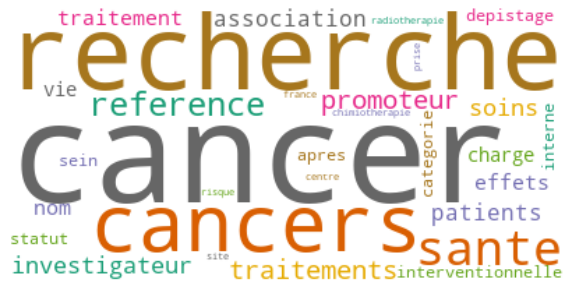

In [24]:

word_cloud(text_health_medical)


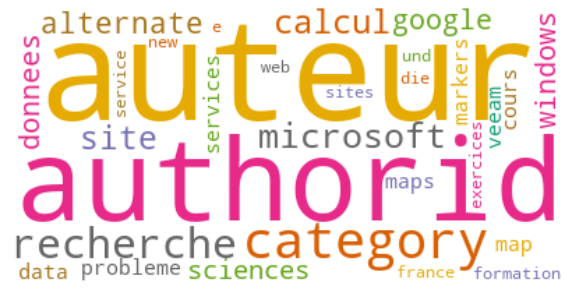

In [32]:
word_cloud(text_tech_science)

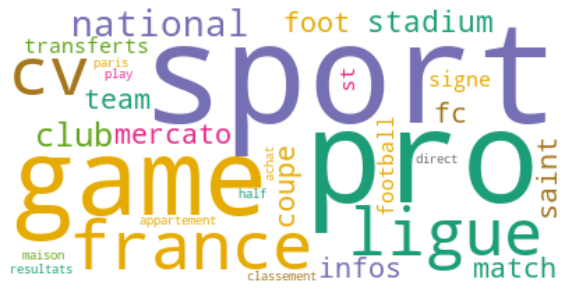

In [26]:
word_cloud(text_sports)

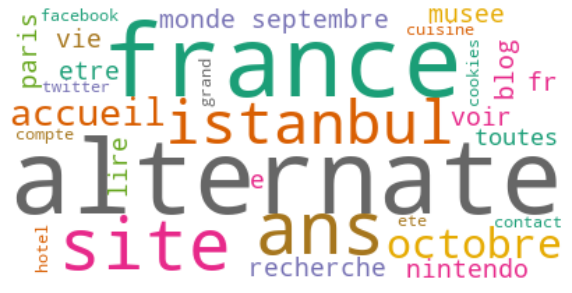

In [33]:
word_cloud(text_entertainment)

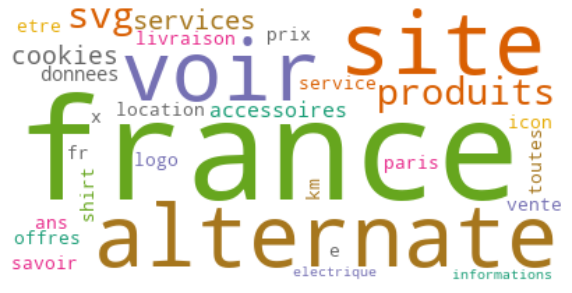

In [28]:
word_cloud(text_business_finance)

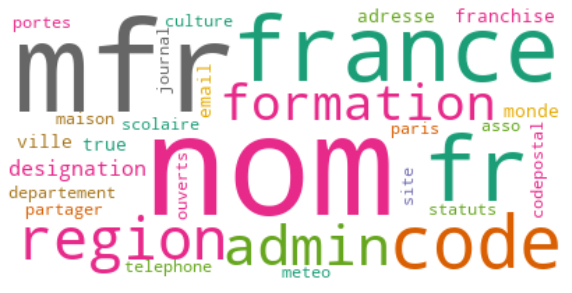

In [34]:
word_cloud(text_news_press)

## TF-IDF + Word2Vec for doc embeddings

In [30]:
!pip3 install unidecode
# !wget http://embeddings.net/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin
!wget http://embeddings.net/frWac_no_postag_no_phrase_500_skip_cut100.bin

/bin/sh: pip3: command not found
/bin/sh: wget: command not found


In [31]:
import gensim
from unidecode import unidecode
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from nltk.tokenize import word_tokenize

#wv_from_bin = KeyedVectors.load_word2vec_format('frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin', binary=True)
wv_from_bin = KeyedVectors.load_word2vec_format('frWac_no_postag_no_phrase_500_skip_cut100.bin', binary=True)

FileNotFoundError: [Errno 2] No such file or directory: 'frWac_no_postag_no_phrase_500_skip_cut100.bin'

In [ ]:
data_train.rename(columns={'train_host': 'host'}, inplace=True)
data_test.rename(columns={'test_host': 'host'}, inplace=True)
data_all = pd.concat([data_train[['host', 'text']], data_test[['host', 'text']]], ignore_index=False)
data_all.set_index('host', inplace=True)
data_all.fillna('', inplace=True)

In [ ]:
#Attention, on a des NaN dans les textes
data_train[data_train.isnull().values]

In [ ]:
data_test[data_test.isnull().values]

In [ ]:
wv_from_bin["sommes"]

In [ ]:
dataset = [v[0] for v in data_all[['text']].values]
print('a')
dataset_tokenized = [word_tokenize(doc, language='french') if len(doc) > 0 else [] for doc in dataset]
print('a')
dct = Dictionary(dataset_tokenized, prune_at=1000000) 
print('a')
corpus = [dct.doc2bow(doc) for doc in dataset_tokenized]
print('a')
model = TfidfModel(corpus)

In [ ]:
try:
    doc_embeds = pickle.load(open('doc_embeds_lem.pkl', 'rb'))
except:
    doc_embeds = {}
    # for fn, doc in zip(filenames, corpus):
    for i, row in enumerate(data_all.iterrows()):
        doc_embed = np.zeros(500)
        doc = corpus[i]
        doc_tfidf = model[doc]
        l = 1
        for word_id, freq in doc_tfidf:
            try:
                word = dct[word_id]
                if len(word) > 1:
                    word_embed = wv_from_bin[dct[word_id]]
                    doc_embed += freq * word_embed
                    l += 1
            except:
                pass
        # doc_embeds.append(doc_embed / l)
        doc_embeds[row[0]] = doc_embed / l
    pickle.dump(doc_embeds, open('doc_embeds_lem.pkl', 'wb'))

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2, perplexity=5)

my_pca_fit = my_pca.fit_transform(doc_embeds)
my_tsne_fit = my_tsne.fit_transform(my_pca_fit)

plt.scatter(my_tsne_fit[:, 0], my_tsne_fit[:, 1],s=3) ### fill the gap ###

In [ ]:
"l'bête".isalpha()